Load Dataset

In [63]:
import numpy as np

In [64]:
data = np.genfromtxt('dataset/processed.cleveland.data', delimiter=',', dtype=str)
data[data == '?'] = np.nan
data = data.astype(float)

Remove rows with missing values

In [65]:
rows_without_nan = ~np.isnan(data).any(axis=1)

cleaned_data = data[rows_without_nan]

labels = cleaned_data[:, -1]
cleaned_data = cleaned_data[:, :-1]

print(cleaned_data)

[[63.  1.  1. ...  3.  0.  6.]
 [67.  1.  4. ...  2.  3.  3.]
 [67.  1.  4. ...  2.  2.  7.]
 ...
 [68.  1.  4. ...  2.  2.  7.]
 [57.  1.  4. ...  2.  1.  7.]
 [57.  0.  2. ...  2.  1.  3.]]


Standard Normalize

In [66]:
mean = np.mean(cleaned_data)
std_dev = np.std(cleaned_data)
z_score = (cleaned_data - mean) / std_dev

PCA

Explained Variance:  [7.46243578e-01 1.49787648e-01 8.57955289e-02 1.60023313e-02
 1.01307682e-03 3.30072242e-04 2.50801576e-04 2.22000205e-04
 1.76402998e-04 5.92782847e-05 4.75020518e-05 4.06039465e-05]


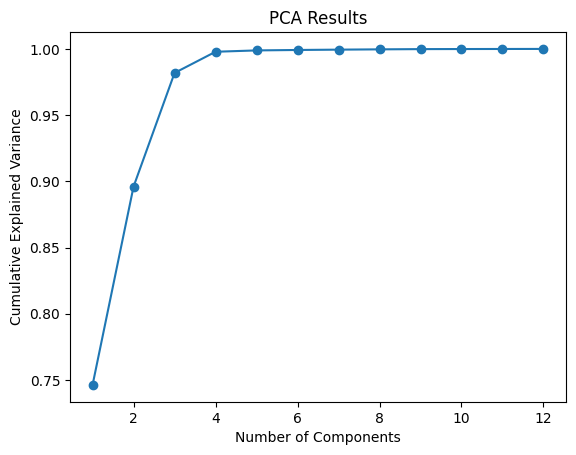

In [67]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=12)
principal_components =  pca.fit_transform(cleaned_data)

explained_variance = pca.explained_variance_ratio_
print("Explained Variance: ", explained_variance)
cumulative_explained_variance = np.cumsum(explained_variance)
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Results')
plt.show()


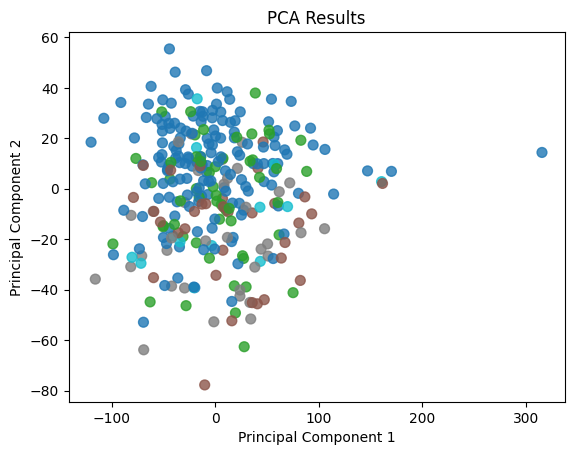

In [68]:
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=labels, cmap='tab10', s=50, alpha=0.8)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Results')
plt.show()

In [56]:
from sklearn.metrics import silhouette_score
score = silhouette_score(cleaned_data, labels)
print("Silhouette: ", score)

Silhouette:  0.0981475046071792


In [57]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

In [58]:
eps_values = np.linspace(0.1, 20.0, 50)       # try 50 values from 0.1 to 20.0
min_samples_values = range(2, 11) 

best_score = -1
best_params = None
results = []

for eps in eps_values:
    for min_s in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_s)
        labels = db.fit_predict(cleaned_data)
        # need at least 2 clusters (ignoring noise) to compute silhouette
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters < 2:
            continue

        score = silhouette_score(cleaned_data, labels)
        results.append((eps, min_s, score))
        if score > best_score:
            best_score = score
            best_params = (eps, min_s)

print(f"Best silhouette={best_score:.3f} with eps={best_params[0]:.3f}, min_samples={best_params[1]}")

Best silhouette=0.098 with eps=19.594, min_samples=6


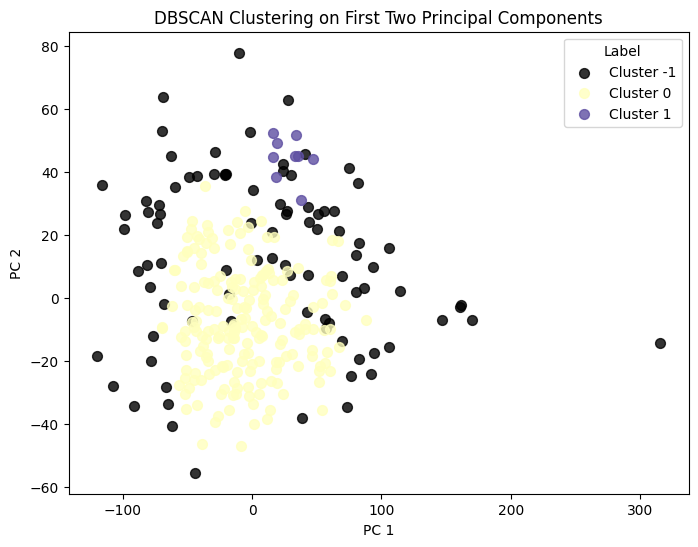

In [59]:


labels = DBSCAN(eps=best_params[0], min_samples=best_params[1]).fit_predict(cleaned_data)
# — or, to cluster in PC-space:
# labels = DBSCAN(eps=0.5, min_samples=5).fit_predict(principal_components[:, :2])

# 3) Extract the first two PCs
pc1 = principal_components[:, 0]
pc2 = principal_components[:, 1]

# 4) Plot
plt.figure(figsize=(8, 6))
unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for lab, col in zip(unique_labels, colors):
    mask = (labels == lab)
    if lab == -1:
        # noise
        col = 'k'
    plt.scatter(
        pc1[mask],
        pc2[mask],
        c=[col],
        label=f'Cluster {lab}',
        s=50,
        alpha=0.8
    )

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('DBSCAN Clustering on First Two Principal Components')
plt.legend(title='Label')
plt.show()